In [941]:
import pandas as pd
import numpy as np
from sklearn import svm, cross_validation
from sklearn import tree, preprocessing
from sklearn import decomposition as decomp
from sklearn import manifold
from sklearn import linear_model
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
np.set_printoptions(suppress=True, precision=3)
from util import *

### Load the data

In [1164]:
# Let's also confine ourselves to one run-time and one assay type
sdf = pd.load("/Users/Alex/Code/blurd/data.pandas")
sdf = sdf[(sdf.run_time == 10) & (sdf.ida == "IDA2") & (sdf.good == True) & (sdf.blood_type != "")]# & (sdf.blood_type != "normal")]
isdf = sdf.copy()

In [1158]:
data = np.vstack(isdf.data.values)

(0.0, 268.0, 0.46293392777442932, 0.95617306232452393)

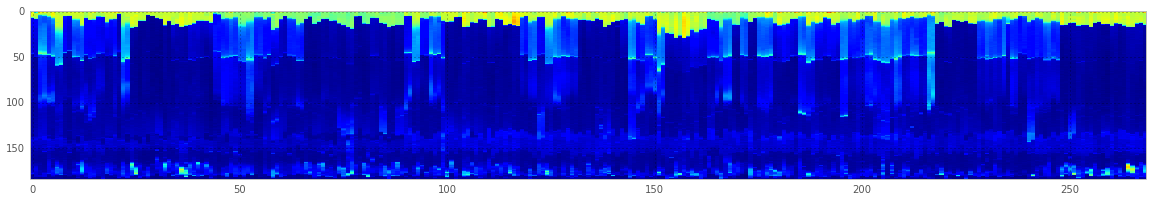

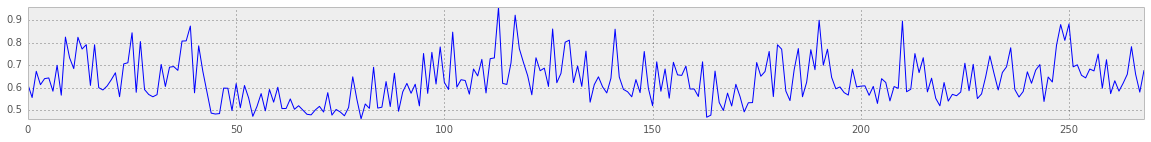

In [1150]:
figure(figsize=(20,3))
imshow(data[:,1:].T)
# xlim(0,20)
figure(figsize=(20,2))
plot(data[:,1:].max(1))
axis('tight')
# xlim(0,20)

In [149]:
tt_idx = isdf.MCV/isdf.RBC < 13
isdf['blood_type'][tt_idx] = 'tt'
isdf['blood_type'][tt_idx==False] = 'ida'

### The Agenda

Things to try/change in data analysis  
  

·         Consider hemolysis in plasma - try to cut off the tube in order to exclude the plasma/lysed RBCs

·         Bin the data by HGB (hemoglobin) or HCT (hematocrit)

·         Bin data into cutoff regimes for % hypo - can we do discrete or continuous categories?

·         Pull out and analyze the 8% of tests that the learning software is not calling as positive and analyze them

·         Check if any (false) positives have a normal MCH but a high hypo --> suggesting swollen cells. 



In [1165]:
dd = np.vstack(isdf['data'].values)

In [1166]:
kmeans = KMeans(12).fit(dd)
idx = np.argsort(kmeans.labels_)

### Bird's-eye view of false and true positives

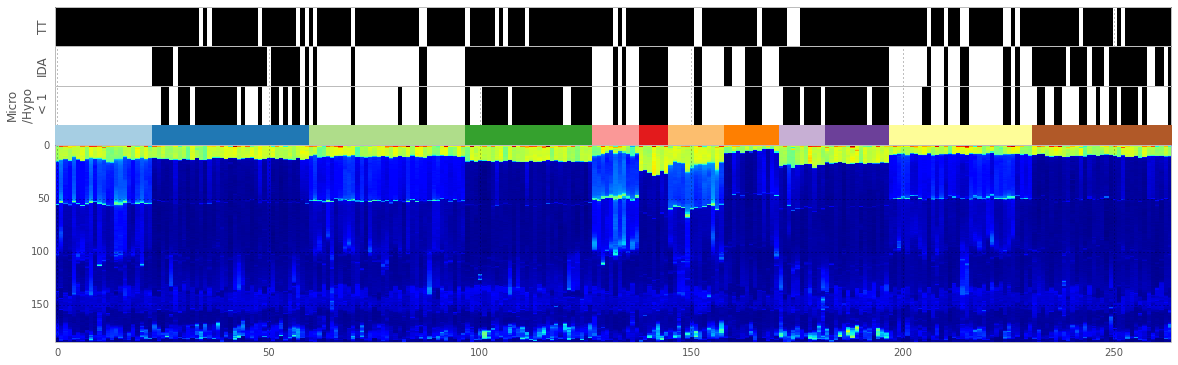

In [1167]:
figure(figsize=(20,6))
gs = GridSpec(5,1, height_ratios=[2,2,2,1,10], hspace=0)
subplot(gs[0])
imshow((isdf.blood_type == "tt")[None,idx], cmap='bone')
ylabel("TT"); yticks([])
subplot(gs[1])
imshow((isdf.blood_type == "ida")[None,idx], cmap='bone')
ylabel("IDA"); yticks([])
subplot(gs[2])
ida_diagnosis = isdf['%Micro'].values[idx] / isdf['%Hypo'].values[idx] < 1.0
imshow(ida_diagnosis[None,:], cmap='bone')
ylabel("Micro\n/Hypo\n < 1"); yticks([])
axis('tight')
subplot(gs[3])
imshow(kmeans.labels_[idx][None,:], cmap='Paired'); axis('off')
subplot(gs[4])
imshow(dd[idx].T)

In [1141]:
print isdf.ida.values[idx[4]]
print isdf.tiff_file.values[idx[4]]
print isdf.tiff_file_position.values[idx[4]]
print isdf.sample.values[idx[4]]

IDA2
/Users/Alex/Dropbox/Science/side projects/Blood Testing/data/3-11-14 Blood Testing/IDA2_GGhhii_IDA3_GGhhii_4min.tiff
(1, 0)
I


/Users/Alex/Dropbox/Science/side projects/Blood Testing/data/1-12-14 Blood Testing/IDA2_aabbccddeeff_10min.tiff.tiff
/Users/Alex/Dropbox/Science/side projects/Blood Testing/data/1-12-14 Blood Testing/IDA2_aabbccddeeff_10min.tiff.tiff
/Users/Alex/Dropbox/Science/side projects/Blood Testing/data/1-12-14 Blood Testing/IDA2_gghhiijjkkll_10min.tiff.tiff
/Users/Alex/Dropbox/Science/side projects/Blood Testing/data/1-12-14 Blood Testing/IDA2_gghhiijjkkll_10min.tiff.tiff
/Users/Alex/Dropbox/Science/side projects/Blood Testing/data/1-12-14 Blood Testing/IDA2_gghhiijjkkll_10min.tiff.tiff
/Users/Alex/Dropbox/Science/side projects/Blood Testing/data/1-12-14 Blood Testing/IDA2_gghhiijjkkll_10min.tiff.tiff
/Users/Alex/Dropbox/Science/side projects/Blood Testing/data/1-9-14 Blood Testing/IDA2_aabbccddeeff_10min.tiff.tiff
/Users/Alex/Dropbox/Science/side projects/Blood Testing/data/1-9-14 Blood Testing/IDA2_aabbccddeeff_10min.tiff.tiff
/Users/Alex/Dropbox/Science/side projects/Blood Testing/data/1-9-1

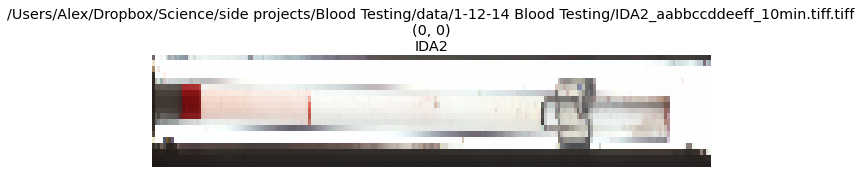

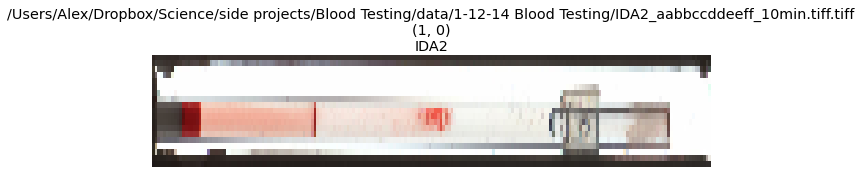

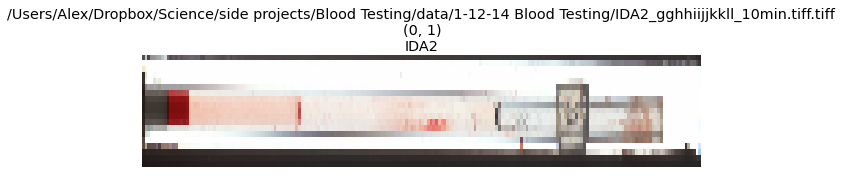

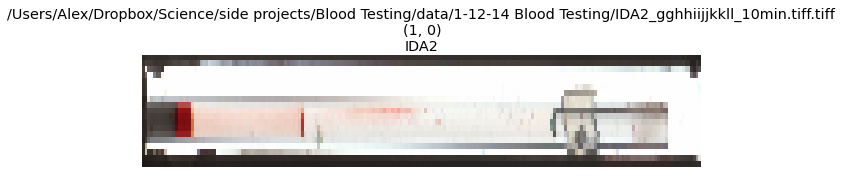

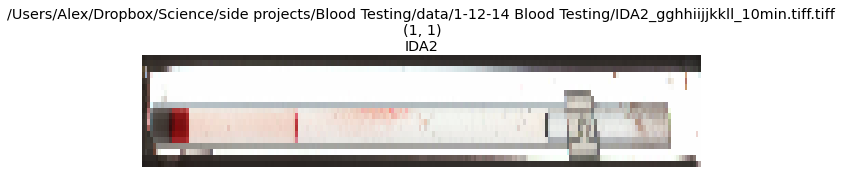

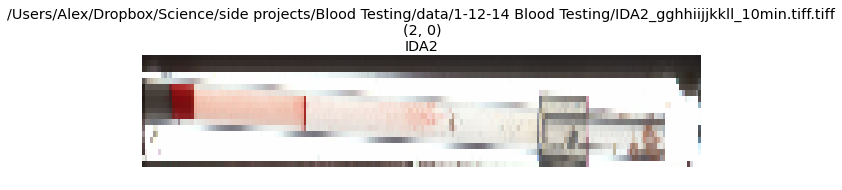

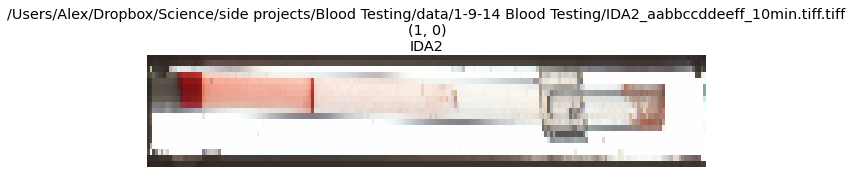

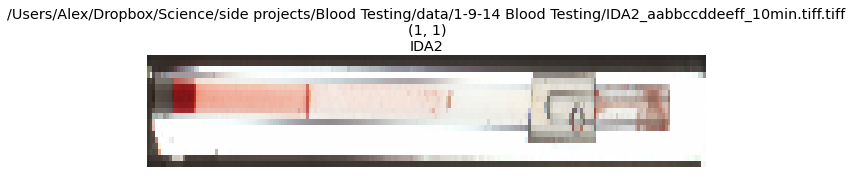

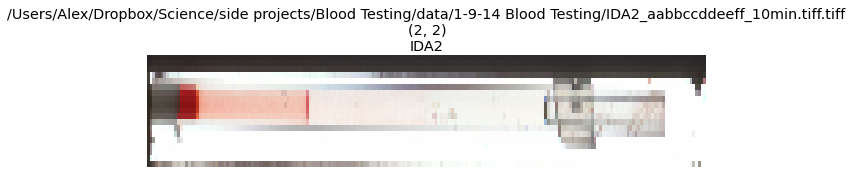

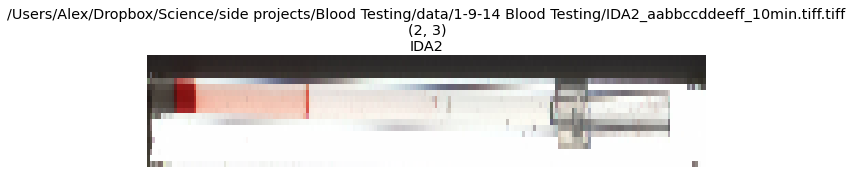

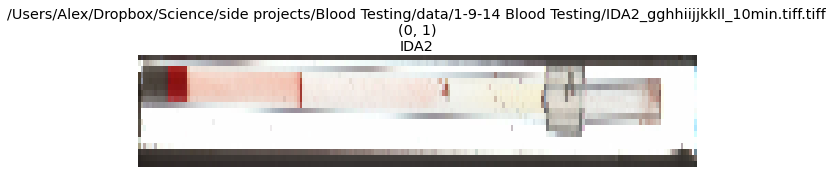

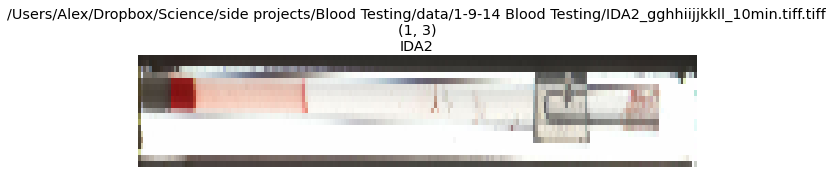

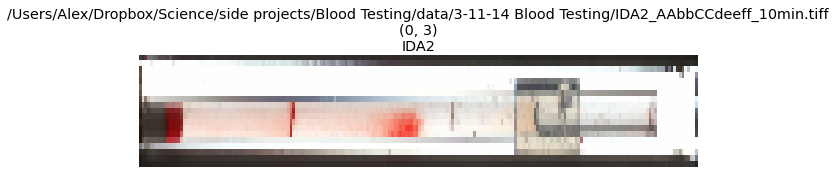

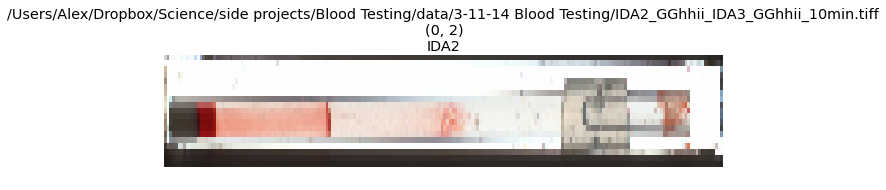

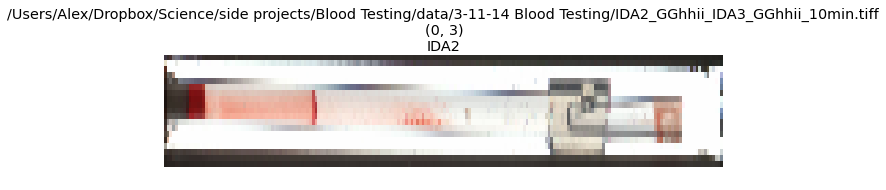

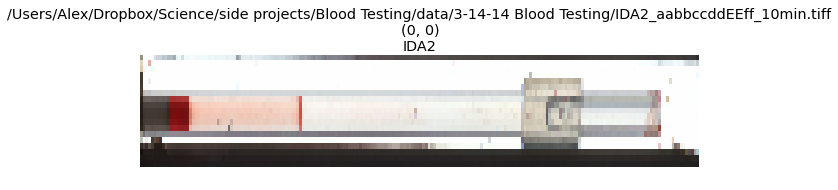

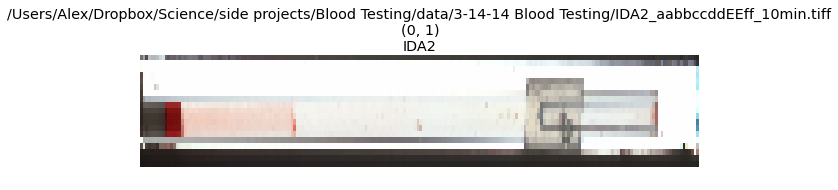

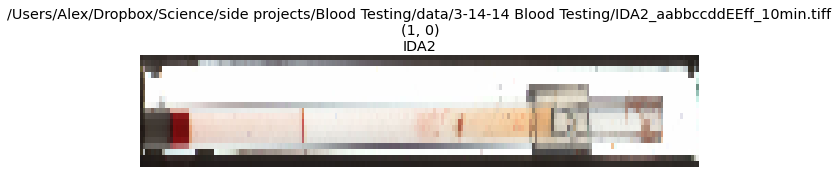

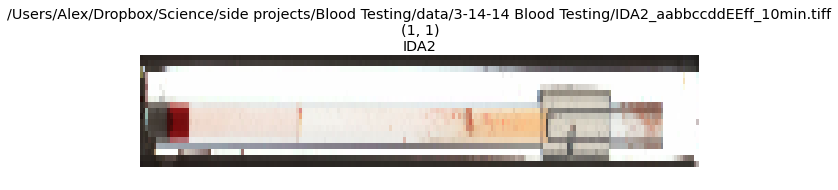

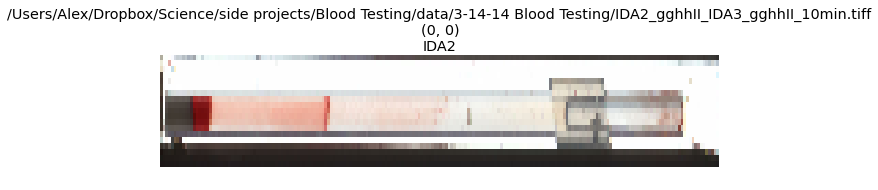

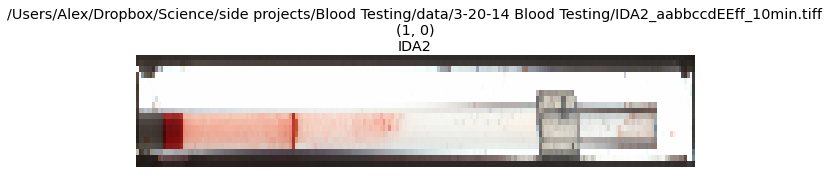

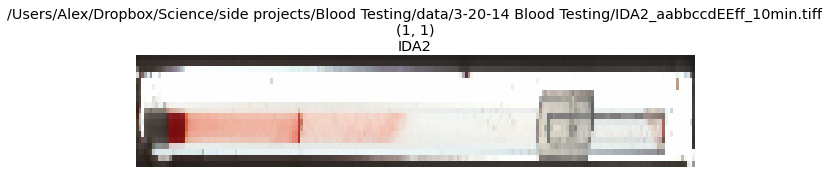

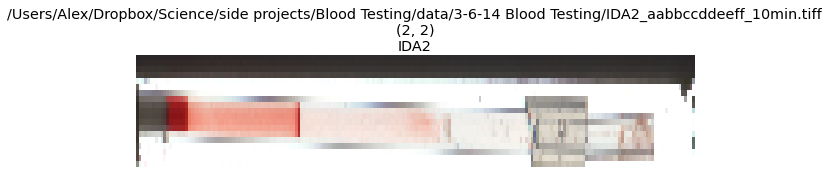

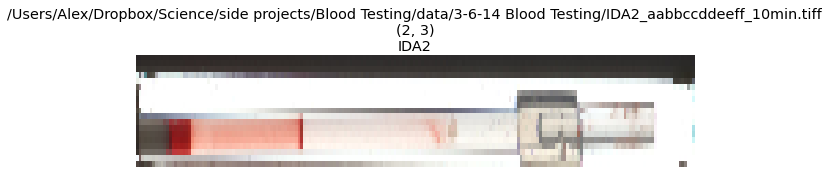

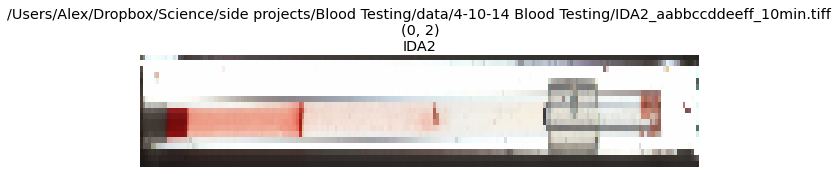

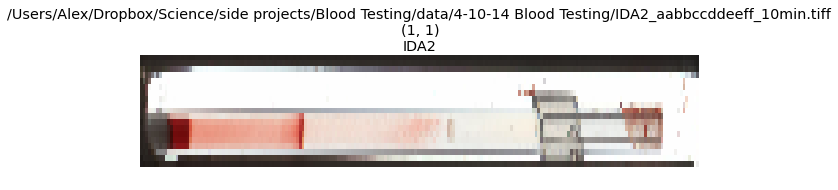

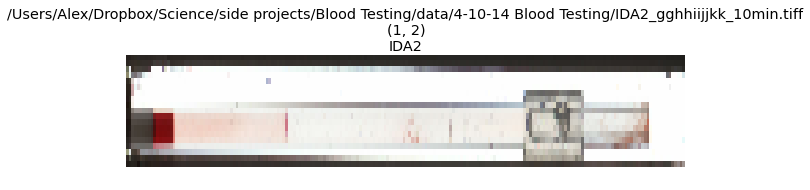

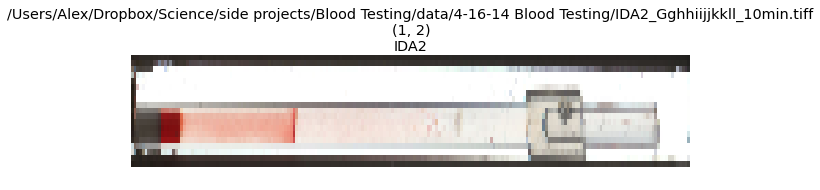

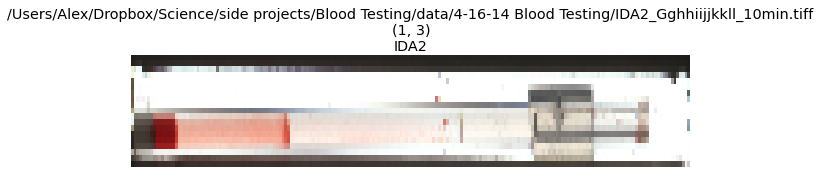

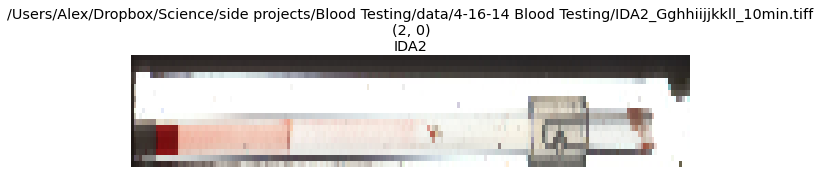

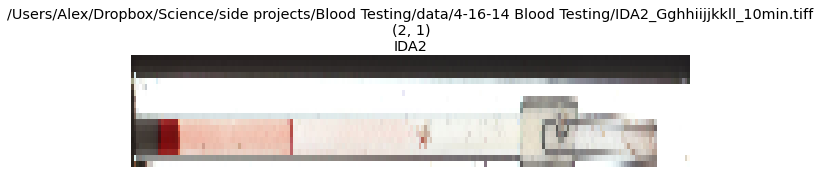

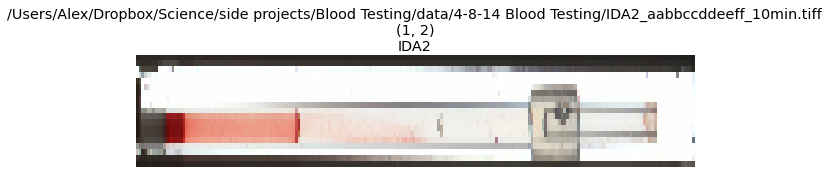

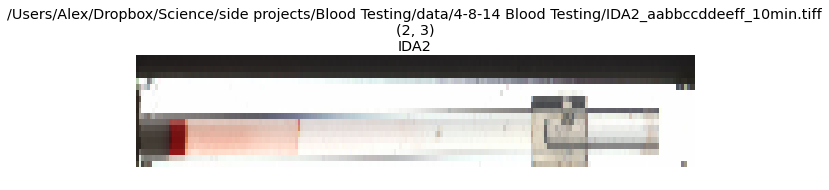

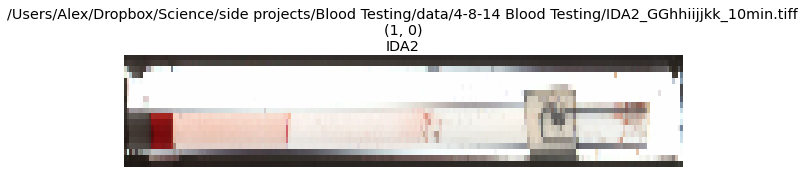

In [1168]:
idx = np.argwhere(kmeans.labels_==10).ravel()
for i in idx:
    figure(figsize=(10,2))
    imshow(np.swapaxes(isdf.image.values[i].astype('uint8'), 0,1));  yticks([]); axis('tight'); axis('off'); 
    title(isdf.tiff_file.values[i] + "\n" + str(isdf.tiff_file_position.values[i]) + "\n" + isdf.ida.values[i])
    print isdf.tiff_file.values[i]

In [1034]:
orig_blood_type = isdf.blood_type.copy()
isdf.blood_type[(isdf.blood_type == "ida") | (isdf.blood_type == "tt")] = "anemic"
data = np.vstack(isdf.data)
labels = isdf.blood_type.values
y,unique_y = unique_indices(labels)
y = y.astype('int32')  

guess_labels, true_labels, test_idx, yscores = classify(data[:,:120], y, n_folds=100, C=100)

Precision: 0.940373, Recall: 0.933556


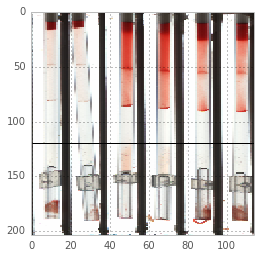

In [47]:
# Consider hemolysis in plasma - try to cut off the tube in order to exclude the plasma/lysed RBCs
cutoff = 120
figure(figsize=(4,4))
I = np.hstack(isdf.image.values[0:6])
imshow(I)
hlines(cutoff, 0, I.shape[1])

### Bin data for classification

We want to be able to predict bloodwork results with the multi-phase assay.  
A simple way to try this is to roughly bin the data by some blood parameter, and do multi-class logistic regression.  

In [314]:
# Bin the data by HGB (hemoglobin)
hemoglobin = isdf['HGB'].values.astype('float32')
bins = np.linspace(hemoglobin.min(), hemoglobin.max(), 3) # TODO: rational bins
hemoglobin_bins = np.digitize(hemoglobin, bins, right=True)

data = np.vstack(isdf.data)
labels = hemoglobin_bins
guess_labels, true_labels, test_idx, yscores = classify(data, labels, n_folds=50, C=0.03)

Precision: 0.647457, Recall: 0.643948


In [317]:
# Bin by HCT (hematocrit)
hematocrit = isdf['HCT'].values.astype('float32')
bins = np.linspace(hematocrit.min(), hematocrit.max(), 3) # TODO: rational bins
hematocrit_bins = np.digitize(hematocrit, bins, right=True)

data = np.vstack(isdf.data)
labels = hematocrit_bins
guess_labels, true_labels, test_idx, yscores = classify(data, labels, n_folds=50, C=0.03)

Precision: 0.659698, Recall: 0.610725


In [320]:
# Bin data into cutoff regimes for % hypo - can we do discrete or continuous categories?
hypo = np.array(isdf['%Hypo'].values, dtype='float32')
bins = np.linspace(0, 100, 10)
hypo_bins = np.digitize(hypo, bins, right=True)

data = np.vstack(isdf.data)
labels = hypo_bins
guess_labels, true_labels, test_idx, yscores = classify(data, labels, n_folds=50, C=0.03)

-c:15: UserWarning: The sum of true positives and false positives are equal to zero for some labels. Precision is ill defined for those labels [7]. The precision and recall are equal to zero for some labels. fbeta_score is ill defined for those labels [3 7]. 
-c:15: UserWarning: The sum of true positives and false positives are equal to zero for some labels. Precision is ill defined for those labels [4]. The precision and recall are equal to zero for some labels. fbeta_score is ill defined for those labels [4]. 
-c:15: UserWarning: The precision and recall are equal to zero for some labels. fbeta_score is ill defined for those labels [4]. 
-c:15: UserWarning: The sum of true positives and false positives are equal to zero for some labels. Precision is ill defined for those labels [5]. The precision and recall are equal to zero for some labels. fbeta_score is ill defined for those labels [5]. 
-c:15: UserWarning: The sum of true positives and false positives are equal to zero for some l

Precision: 0.690373, Recall: 0.691111


In [341]:
# Pull out and analyze the 8% of tests that the learning software is not calling as positive and analyze them
orig_blood_type = isdf.blood_type.copy()
isdf.blood_type[(isdf.blood_type == "ida") | (isdf.blood_type == "tt")] = "anemic"
data = np.vstack(isdf.data)
labels = isdf.blood_type.values
y,unique_y = unique_indices(labels)
y = y.astype('int32')  
n_folds = 50
guess_labels, true_labels, test_idx, yscores = classify(data, y, n_folds=n_folds, C=0.03)

Precision: 0.923666, Recall: 0.961357


In [371]:
false_calls = np.sort(np.hstack([tidx[g!=t] for g,t,tidx in zip(guess_labels, true_labels, test_idx)]))
n_false_calls_per_sample = np.bincount(false_calls, minlength=len(isdf))/float(n_folds)
hard_samples = np.argwhere(n_false_calls_per_sample > 0).ravel()
easy_samples = np.argwhere(n_false_calls_per_sample == 0).ravel()

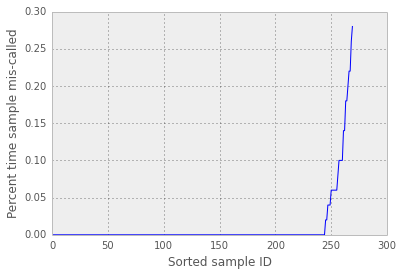

In [372]:
# It looks like there's a relatively limited population of "hard" samples
plot(np.sort(n_false_calls_per_sample))
ylabel("Percent time sample mis-called")
xlabel("Sorted sample ID")

In [373]:
isdf.iloc[easy_samples][['%Hyper', '%Hypo', '%Macro', '%Micro/%Hypo Ratio', 'Age', 'MCH']]

,%Hyper,%Hypo,%Macro,%Micro/%Hypo Ratio,Age,MCH
24,2.2,11.9,0.1,1.39,4,25.2
25,2.2,11.9,0.1,1.39,4,25.2
26,0.1,70.7,1.4,0.05,32,24.9
27,0.1,70.7,1.4,0.05,32,24.9
28,1.2,31.5,8.2,0.07,1.333333,28.4
29,1.2,31.5,8.2,0.07,1.333333,28.4
30,0.5,12.2,4.1,0.11,2,28.5
31,0.5,12.2,4.1,0.11,2,28.5
32,0.5,20.4,0.2,0.42,14,23.6
34,0.5,24.1,0,0.75,19,21.3


In [370]:
isdf.iloc[hard_samples][['%Hyper', '%Hypo', '%Macro', '%Micro/%Hypo Ratio', 'Age', 'MCH']]

,%Hyper,%Hypo,%Macro,%Micro/%Hypo Ratio,Age,MCH
33,0.5,20.4,0.2,0.42,14,23.6
210,0.9,1.1,0.1,1.18,17,27.8
212,1.1,0.3,0.1,3.85,11,26.9
213,1.1,0.3,0.1,3.85,11,26.9
513,0.7,42.2,0.9,0.08,1.166667,25
566,2.9,4.5,4.9,3.64,0.05753425,26.7
567,2.9,4.5,4.9,3.64,0.05753425,26.7
568,0.1,12.8,0.7,0.31,12,26.8
569,0.1,12.8,0.7,0.31,12,26.8
689,1.2,3.9,1.9,0.15,0.6666667,31.2


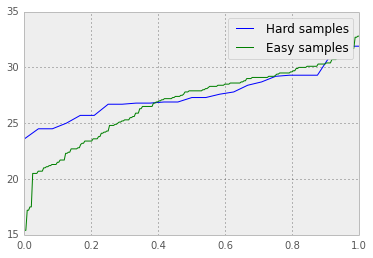

In [377]:
plot(np.linspace(0,1,len(hard_samples)), np.sort(isdf.iloc[hard_samples]['MCH']))
plot(np.linspace(0,1,len(easy_samples)), np.sort(isdf.iloc[easy_samples]['MCH']))
legend(["Hard samples", "Easy samples"])

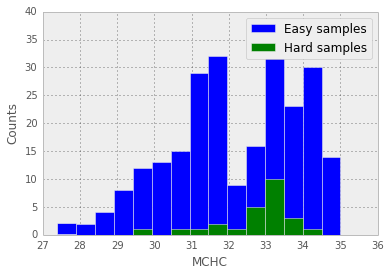

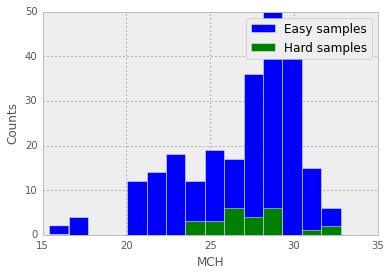

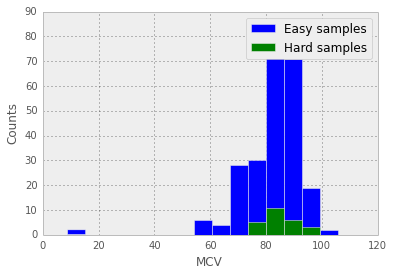

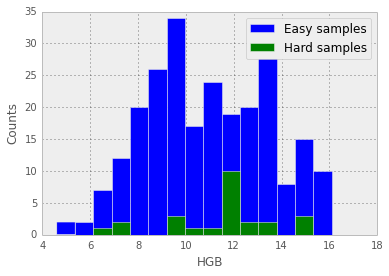

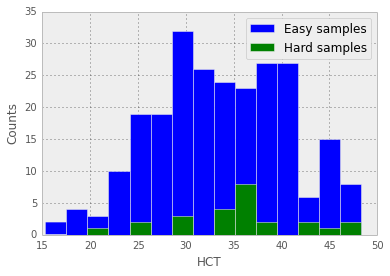

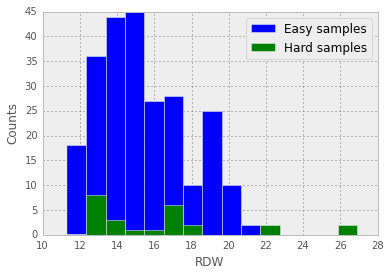

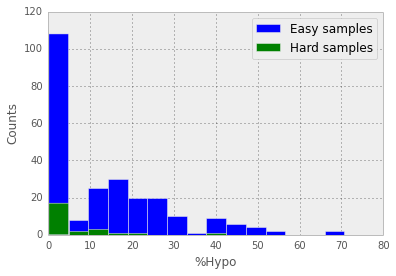

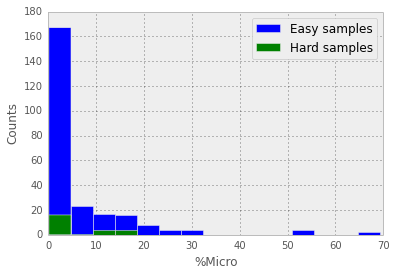

In [389]:
for val in ["MCHC", "MCH", "MCV", "HGB", "HCT", "RDW", "%Hypo", "%Micro"]:
    figure()
    this_range = (isdf[val].min(), isdf[val].max())
    hist(isdf.iloc[easy_samples][val].values, bins=15, range=this_range)
    hist(isdf.iloc[hard_samples][val].values, bins=15, range=this_range)
    legend(["Easy samples", "Hard samples"])
    xlabel(val)
    ylabel("Counts")

In [420]:
# Bad samples: 
zip((100*n_false_calls_per_sample[hard_samples]).astype('int32'), 
    isdf.sample.iloc[hard_samples], 
    [s.split("/")[-1] for s in isdf.excel_file.iloc[hard_samples].values])

[(4, 'E', '1-12-14 Blood Info.xlsx'),
 (10, 'V', '1-12-14 Blood Info.xlsx'),
 (6, 'W', '1-12-14 Blood Info.xlsx'),
 (6, 'W', '1-12-14 Blood Info.xlsx'),
 (6, 'E', '1-9-14 Blood Data with Intensity Data.xlsx'),
 (4, 'H', '1-9-14 Blood Data with Intensity Data.xlsx'),
 (2, 'H', '1-9-14 Blood Data with Intensity Data.xlsx'),
 (18, 'I', '1-9-14 Blood Data with Intensity Data.xlsx'),
 (26, 'I', '1-9-14 Blood Data with Intensity Data.xlsx'),
 (6, 'U', '1-9-14 Blood Data with Intensity Data.xlsx'),
 (10, 'I', '3-11-14 Blood Info.xlsx'),
 (2, 'R', '3-14-14 Blood Data.xlsx'),
 (6, 'S', '3-14-14 Blood Data.xlsx'),
 (10, 'S', '3-14-14 Blood Data.xlsx'),
 (4, 'N', '3-20-14 Blood Data.xlsx'),
 (10, 'Q', '3-20-14 Blood Data.xlsx'),
 (14, 'Q', '3-20-14 Blood Data.xlsx'),
 (18, 'R', '3-20-14 Blood Data.xlsx'),
 (14, 'B', '3-6-14 Blood Data.xlsx'),
 (22, 'E', '3-6-14 Blood Data.xlsx'),
 (20, 'E', '3-6-14 Blood Data.xlsx'),
 (22, 'A', '4-10-14 Blood Data.xlsx'),
 (28, 'A', '4-10-14 Blood Data.xlsx'),
 (